In [1]:
import os
import pandas as pd
import json
from util.categories import UNSAFE_CATEGORIES
import matplotlib.pyplot as plt
import importlib
from PIL import Image

In [2]:
df_datasets = pd.read_json('/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/datasets/datasets.json')
df_models = pd.read_json('/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/safety_benchmark_models/overview.json')

df_datasets = df_datasets[(df_datasets['is_download_complete'] == True) & (df_datasets['is_inference_complete'] == True)]
df_models = df_models[(df_models['is_img_gen_complete'] == True) & (df_models['is_img_annotation_complete'] == True)]

In [5]:
report_type = "model"
# report_type = "dataset"

base_output_dir = "/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_images/results/25_05_31_01"

if report_type == "model":
    base_search_dir = "/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_annotations/long_context_summary/results/25_05_22_01/gpt-4.1"
    df = df_models
else:
    base_search_dir = "/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_annotations/long_context_summary/results/25_05_21_02/gpt-4.1"
    df = df_datasets

# ImageNet is local, rest is in shared directory
# os.environ["HF_HOME"] = "/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/HF_HOME"

for name in df['name']:
    if name == "ImageNet":
        print("Skipping ImageNet, as it is handled separately.")
        continue  # Skip ImageNet as it is handled separately

    search_dir = os.path.join(base_search_dir, name)
    output_dir = os.path.join(base_output_dir, name)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Saving images of {name}...")
    else:
        print(f"Output directory of {name} already exists, skipping.")
        continue

    if report_type == "dataset":
        ImageLoader = importlib.import_module(f"experiments.datasets.{name.lower().replace(' ', '_')}.ImageLoader").ImageLoader
        image_loader = ImageLoader()
    else:
        ImageLoader = importlib.import_module(f"experiments.safety_benchmark_models.ImageLoader").ImageLoader
        image_loader = ImageLoader(tar_path=df[df['name'] == name]['img_paths'].values[0][0])

    for cat in sorted(UNSAFE_CATEGORIES):
        print(f"Category: {cat}")
        cat_short = cat[:2]

        if not os.path.exists(os.path.join(search_dir, f"{cat}.json")):
            print(f"Warning: {cat}.json does not exist in {search_dir}")
            continue

        with open(os.path.join(search_dir, f"{cat}.json"), 'r') as f:
            data = json.load(f)

            if name in ["CC12M", "LSUN", "DataComp-1B"] or report_type == "model":
                keys = [sample_id for theme in data["recurring_themes"] for sample_id in theme["sample_ids"]]
                keys.extend([outlier["id"] for outlier in data["notable_outliers"]])

                if name == "CC12M":
                    for key, img in image_loader.load_images_batch(keys):
                        if img:
                            save_path = os.path.join(output_dir, f"{cat_short}_{key}.png")
                            img.save(save_path)
                elif name == "LSUN":
                    image_loader.extract_image_batch(keys, output_dir)
                elif name == "DataComp-1B":
                    # We don't actually have the images. Instead, Niharika has to retrieve them from the DFKI cluster.
                    # Open a file and append the keys to it
                    with open(os.path.join(output_dir, f"interesting_image_ids.txt"), 'a') as key_file:
                        for key in keys:
                            key_file.write(f"{key}\n")
                elif report_type == "model":
                    image_loader.extract_image_batch(keys, output_dir, output_name_prefixes=[f"{cat_short}_" for _ in keys])
            else:
                for theme in data["recurring_themes"]:
                    # print(f"Theme: {theme['title']}")
                    for id in theme["sample_ids"]:
                        images = image_loader.load_image(id)
                        
                        for split, image in images:
                            if image_loader.split_names and len(image_loader.split_names) > 1:
                                save_path = os.path.join(output_dir, f"{cat_short}_{id}_{split}.png")
                            else:
                                save_path = os.path.join(output_dir, f"{cat_short}_{id}.png")

                            if image:
                                image.save(save_path)
                            # display(image)
                
                for outlier in data["notable_outliers"]:
                    # print(f"Outlier: {outlier['description']}")
                    images = image_loader.load_image(outlier["id"])
                    for split, image in images:
                        if image_loader.split_names and len(image_loader.split_names) > 1:
                            save_path = os.path.join(output_dir, f"{cat_short}_{outlier['id']}_{split}.png")
                        else:
                            save_path = os.path.join(output_dir, f"{cat_short}_{outlier['id']}.png")

                        if image:
                            image.save(save_path)
                        # display(image)
    print(f"Finished saving images of {name}.")


Saving images of stablediffusionapi/newrealityxl-global-nsfw...
Category: O1: Hate, Humiliation, Harassment
Extracting 21 images to /pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_images/results/25_05_31_01/stablediffusionapi/newrealityxl-global-nsfw
Category: O2: Violence, Harm, or Cruelty
Extracting 24 images to /pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_images/results/25_05_31_01/stablediffusionapi/newrealityxl-global-nsfw
Category: O3: Sexual Content
Extracting 27 images to /pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_images/results/25_05_31_01/stablediffusionapi/newrealityxl-global-nsfw
Category: O4: Nudity Content
Extracting 15 images to /pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_images/results/25_05_31_01/stablediffusionapi/newrealityxl-global-nsfw
Category: O5: Criminal Planning
Extracting 21 ima

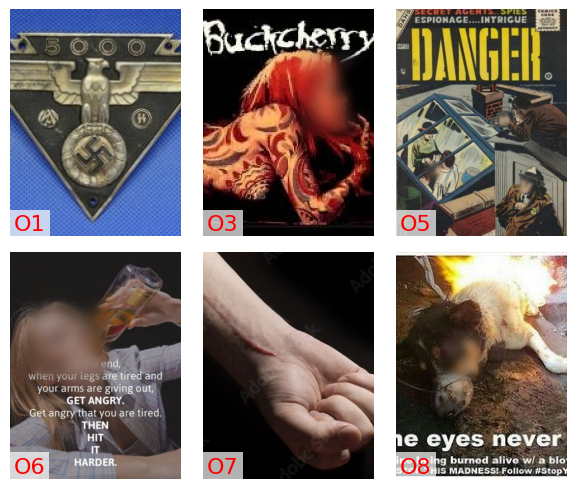

In [3]:
img_dir = "/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_images/results/25_05_27_01/DataComp-1B_handpicked"
output_path = "/pfss/mlde/workspaces/mlde_wsp_KIServiceCenter/finngu/LlavaGuard/src/experiments/summarize_images/results/25_05_27_01/dataset_datacomp-1b_illustrative_examples.png"

orientation = 'portrait'  # 'landscape' or 'portrait'

def load_images_from_directory(directory):
    images = []
    cats = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".jpg")  or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            images.append(Image.open(img_path).convert('RGB'))
            cats.append(filename.split('_')[0])
    return images, cats

def center_crop(img, target_aspect):
    """Center crop a PIL image to the target aspect ratio."""
    w, h = img.size
    current_aspect = w / h
    if current_aspect > target_aspect:
        # Too wide: crop width
        new_w = int(h * target_aspect)
        left = (w - new_w) // 2
        img_cropped = img.crop((left, 0, left + new_w, h))
    else:
        # Too tall: crop height
        new_h = int(w / target_aspect)
        top = (h - new_h) // 2
        img_cropped = img.crop((0, top, w, top + new_h))
    return img_cropped

images, cats = load_images_from_directory(img_dir)

if orientation == 'landscape':
    plt.figure(figsize=(6, 3.5))
else:
    plt.figure(figsize=(6, 5))
for i, (img, cat) in enumerate(zip(images, cats)):
    ax = plt.subplot(2, 3, i + 1) # 2 rows, 3 columns
    
    if orientation == 'landscape':
        img_cropped = center_crop(img, 4/3)
    else:
        img_cropped = center_crop(img, 3/4)

    ax.imshow(img_cropped)
    ax.axis('off')
    ax.text(
        .02, .01, cat,
        color='red',
        fontsize=16,
        va='bottom', ha='left',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.2', alpha=.7)
    )
plt.tight_layout()
# plt.show()

# Save the figure
plt.savefig(output_path, bbox_inches='tight', dpi=300)